In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [72]:
path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\10-03-34single_measurement_PD background noise,\ESA_spectrum_PD background"
path_spectrum = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\2024-02-16_11-28-07single_measurement_EOM_on_80MHz\2024-02-16_11-28-07_ESA_full_spectrum_, EOM on at 80 MHz, ,feedback_None"
path_bg = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\2024-02-16_11-29-30single_measurement_EOM_off\2024-02-16_11-29-30_ESA_full_spectrum_, EOM off,feedback_None"

peak1 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\2024-02-16_16-43-56single_measurement_EOM_on_80MHz\2024-02-16_16-43-56_ESA_peak_spectrum_, EOM on at 80 MHz, ,feedback_-57.08 dB.txt"
peak1_bg = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\2024-02-16_16-43-56single_measurement_EOM_on_80MHz\2024-02-16_16-43-56_ESA_peak_spectrum_, EOM off,feedback_-57.08 dB.txt"

def get_data(path):
    #Returns:
    #freqs: frequency axis in MHz
    #powers: ESA power in dBm 
    data = np.loadtxt(path)
    freqs = data[0,:]*1e-6
    powers = data[1,:]
    return freqs, powers

def plot_spectrum(freqs,powers,label=''):
    plt.plot(freqs,powers,label=label)
    plt.xlabel('Fourier frequency [MHz]')
    plt.ylabel('ESA power [dBm]')


def subtract_background(path_spectrum,path_bg,k=1):
    freqs, powers = get_data(path_spectrum)
    freqs_bg, powers_bg = get_data(path_bg)

    powers_lin = 10**(powers/10)
    powers_bg_lin = 10**(powers_bg/10)

    powers_difference_lin = abs(powers_lin - k*powers_bg_lin)
    powers_difference = 10*np.log10(powers_difference_lin)
    return freqs, powers_difference

def get_subtracted_background(signal,background,k=1, plot=True):
    freqs, powers = get_data(signal)
    freqs_new, powers_new = subtract_background(signal,background,k)
    if plot:
        plot_spectrum(freqs,powers,label='Raw')
        plot_spectrum(freqs_new,powers_new,label='Background subtracted')
        plt.legend()
    return freqs_new, powers_new

def gauss_log(x,a,b):
    return -a*x**2 + b


def lor_log(x,a,df):
    return a + 10*np.log10(df/(df**2 + x**2))

def get_data_from_folder(directory):
    files = os.listdir(directory)
    def path(file):
        return directory + '\\' + file
    return ([path(files[1]), path(files[3])], [path(files[5]), path(files[7])], [path(files[8])])

def load_full_spectrum(directory):
    return




(array([0.000000e+00, 1.599984e-03, 3.199968e-03, ..., 1.599952e+02,
        1.599968e+02, 1.599984e+02]),
 array([-38.82844795, -40.87910556, -44.6508261 , ..., -71.36957635,
        -71.71971269, -72.16663545]))

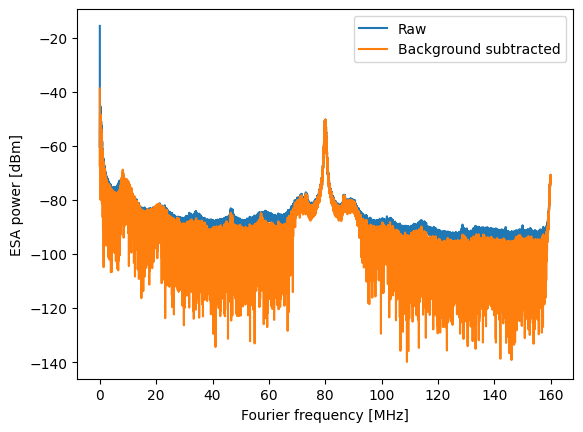

In [73]:
esa_full, esa_close, osa = get_data_from_folder(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\2024-02-16_16-43-56single_measurement_EOM_on_80MHz")
get_subtracted_background(esa_full[1], esa_full[0])


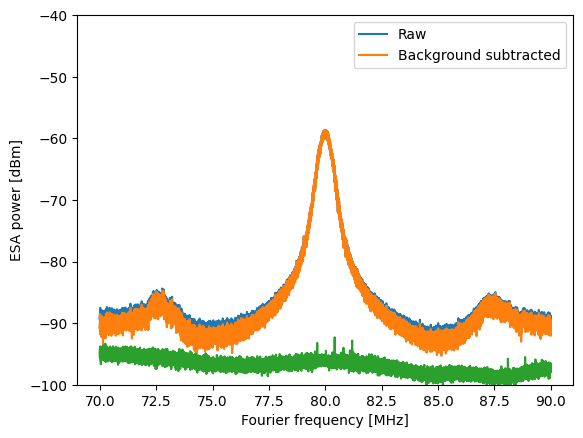

In [29]:
fs, ps = get_subtracted_background(peak1,peak1_bg,k=1)
fs_bg, ps_bg = get_data(peak1_bg)
plot_spectrum(fs_bg, ps_bg)
fs = fs - 80
ps = ps - max(ps)
plt.ylim([-100,-40])
plt.legend()


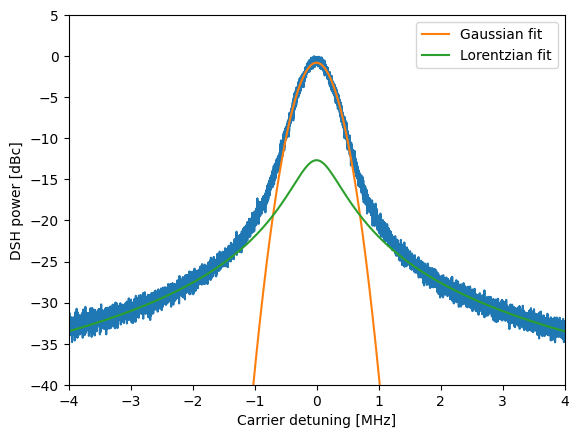

In [163]:

threshold_close = .5
threshold_mid = 2
threshold_far = 3
filter_close = abs(fs) < threshold_close
filter_far = (abs(fs) > threshold_mid) &  (abs(fs) < threshold_far)

fs_close = fs[filter_close]
ps_close = ps[filter_close]
fs_far = fs[filter_far]
ps_far = ps[filter_far]

plt.plot(fs,ps)
params_close,_ = curve_fit(gauss_log,fs_close,ps_close)
params_far,_ = curve_fit(lor_log,fs_far,ps_far)
plt.plot(fs,gauss_log(fs,*params_close),label = 'Gaussian fit')
plt.plot(fs,lor_log(fs,*params_far),label= 'Lorentzian fit')

plt.xlim([-4,4])
plt.ylim([-40,5])
plt.ylabel('DSH power [dBc]')
plt.xlabel('Carrier detuning [MHz]')
plt.legend()